In [1]:
import tcrdist as td
import pandas as pd
from tcrdist.repertoire import TCRrep
from tcrdist.proximity import TCRproximity
import numpy as np
import parasail
from collections import namedtuple

Using Cython-powered Fisher's exact test


In [2]:
# reading the db file
vdj = pd.read_csv('../vdjdb-dump/vdjdb.slim.txt', sep='\t')
vdj.shape

(61557, 16)

In [3]:
# keeping only human entries and beta chains
vdj = vdj.loc[(vdj.species == 'HomoSapiens') & (vdj.gene == 'TRB')]

In [4]:
# counting the number of unique TCRs for an epitope
ge30 = vdj.groupby('antigen.epitope').cdr3.count() >= 30

In [5]:
# removing all epitopes which have less then 30 unique TCRs
vdj = vdj.loc[(vdj['antigen.epitope'].isin(ge30[ge30].index))]

In [6]:
# finding epitopes with more than 1000 unique TCRs
ge1000 = vdj.groupby('antigen.epitope').cdr3.count().sort_values() > 1000

In [7]:
# pseudo-sampling of 1000 rows from each group
# yes, it's just keeping top 1000, will change this later
sampled = vdj.loc[vdj['antigen.epitope'].isin(ge1000.loc[ge1000].index)].groupby('antigen.epitope').head(1000)

In [8]:
# separate df for epitopes which counts are 30 <= x <= 1000
bw30_1000 = vdj.loc[~vdj['antigen.epitope'].isin(ge1000.loc[ge1000].index)]

In [9]:
# concatenating two dfs
vdj = pd.concat([sampled, bw30_1000])

In [10]:
vdj.shape

(13798, 16)

In [11]:
# tcrdist has a specific naming format
# our mapping is not in default lib mappers
mapper = {'complex.id': 'complex_id', 'gene': 'gene', 'cdr3': 'cdr3_b_aa', 'v.segm': 'v_b_gene',
          'j.segm': 'j_b_gene', 'species': 'organism', 'mhc.a': 'mhc_b_a', 'mhc.b': 'mhc_b_b', 
          'mhc.class': 'mhc_b_class', 'antigen.epitope': 'epitope', 'antigen.gene': 'epitope_gene',
          'antigen.species': 'epitope_species', 'reference.id': 'reference', 'vdjdb.score': 'score'}

In [12]:
# dropping unnecessary variables (j.start, v.end) - they do not have corresponding names in the lib
vdj.drop(set(vdj.columns) - mapper.keys(), axis=1, inplace=True)

# renaming columns
vdj.rename(mapper=mapper, axis=1, inplace=True)

In [13]:
# removing references to www.10xgenomics.com
vdj = vdj[~vdj.reference.str.startswith('https://www.10xgenomics.com/resources/applicat')]

In [14]:
# keeping only 100 random rows for now
vdj = vdj.sample(100)
vdj.head()

,gene,cdr3_b_aa,organism,epitope,epitope_gene,epitope_species,complex_id,v_b_gene,j_b_gene,mhc_b_a,mhc_b_b,mhc_b_class,reference,score
16414,TRB,CATTPGASGISEQFF,HomoSapiens,FRDYVDRFYKTLRAEQASQE,Gag,HIV-1,0,TRBV2*01,TRBJ2-1*01,HLA-DRA*01:01,HLA-DRB5*01:01,MHCII,PMID:27111229,3
30,TRB,CASIPEGGRETQYF,HomoSapiens,GLCTLVAML,BMLF1,EBV,0,TRBV7-8*01,TRBJ2-5*01,HLA-A*02:01,B2M,MHCI,PMID:23267020,1
59314,TRB,CASSDLASGTDTQYF,HomoSapiens,FRDYVDRFYKTLRAEQASQE,Gag,HIV-1,0,TRBV2*01,TRBJ2-3*01,HLA-DRA*01:01,HLA-DRB1*11:01,MHCII,PMID:27111229,0
26744,TRB,CSASGSGGKTEAFF,HomoSapiens,PKYVKQNTLKLAT,HA,InfluenzaA,21261,TRBV20-1*01,TRBJ1-1*01,HLA-DRA*01:01,HLA-DRB1*04:01,MHCII,PMID:28636589,0
28335,TRB,CATFSGNTGELFF,HomoSapiens,MLNIPSINV,pp65,CMV,0,TRBV24-1*01,TRBJ2-2*01,HLA-A*02,B2M,MHCI,PMID:25925682,0


In [15]:
# these lines are from example 2
tr = TCRrep(cell_df=vdj, organism="human")

In [16]:
# not sure whether this step is OK: need to figure out more about imgt_aligned argument
tr.infer_cdrs_from_v_gene(chain='beta', imgt_aligned=True)  

In [17]:
# a new attribute after running infer_cdrs_from_v_gene()
tr.cell_df.head()

,gene,cdr3_b_aa,organism,epitope,epitope_gene,epitope_species,complex_id,v_b_gene,j_b_gene,mhc_b_a,mhc_b_b,mhc_b_class,reference,score,cdr1_b_aa,cdr2_b_aa,pmhc_b_aa
16414,TRB,CATTPGASGISEQFF,HomoSapiens,FRDYVDRFYKTLRAEQASQE,Gag,HIV-1,0,TRBV2*01,TRBJ2-1*01,HLA-DRA*01:01,HLA-DRB5*01:01,MHCII,PMID:27111229,3,SNH.......LY,FYN....NEI,P.DGSN
30,TRB,CASIPEGGRETQYF,HomoSapiens,GLCTLVAML,BMLF1,EBV,0,TRBV7-8*01,TRBJ2-5*01,HLA-A*02:01,B2M,MHCI,PMID:23267020,1,SGH.......VS,FQN....EAQ,P.EGSV
59314,TRB,CASSDLASGTDTQYF,HomoSapiens,FRDYVDRFYKTLRAEQASQE,Gag,HIV-1,0,TRBV2*01,TRBJ2-3*01,HLA-DRA*01:01,HLA-DRB1*11:01,MHCII,PMID:27111229,0,SNH.......LY,FYN....NEI,P.DGSN
26744,TRB,CSASGSGGKTEAFF,HomoSapiens,PKYVKQNTLKLAT,HA,InfluenzaA,21261,TRBV20-1*01,TRBJ1-1*01,HLA-DRA*01:01,HLA-DRB1*04:01,MHCII,PMID:28636589,0,DFQ......ATT,SNEG...SKA,A.SLTL
28335,TRB,CATFSGNTGELFF,HomoSapiens,MLNIPSINV,pp65,CMV,0,TRBV24-1*01,TRBJ2-2*01,HLA-A*02,B2M,MHCI,PMID:25925682,0,KGH.......DR,SFD....VKD,Q.AQAK


In [18]:
# these columns will determine duplicates
tr.index_cols = ['epitope', 'cdr3_b_aa', 'cdr1_b_aa', 'cdr2_b_aa', 'pmhc_b_aa', 'v_b_gene', 'j_b_gene']

In [19]:
# this clearly does not work and I need to manualy add a column 'count'
tr.cell_df['count'] = 1
tr.deduplicate()

tcrdist.repertoire.TCRrep for <Your TCR Repertoire Project>
 with index_cols: ['epitope', 'cdr3_b_aa', 'cdr1_b_aa', 'cdr2_b_aa', 'pmhc_b_aa', 'v_b_gene', 'j_b_gene']
 with model organism: human

In [20]:
# computing pairwise distances for beta chains with Needleman–Wunsch algorithm using Blosum62
# this fills such attributes as cdr3_b_aa_pw and also tcrdist (required for the next line)
tr.compute_pairwise_all(chain="beta", metric="nw", processes=4, matrix=parasail.blosum62)

# this fills paired_tcrdist between CDR regions 
tr.compute_paired_tcrdist(store_result=True)

/home/alex/.local/lib/python3.7/site-packages/tcrdist/repertoire.py:649: UserWarning: tcrdist was calculated without: 'cdr1_a_aa_pw' because pairwise distances haven't been computed for this region:
  warnings.warn("tcrdist was calculated without: '{}' because pairwise distances haven't been computed for this region:".format(k))
/home/alex/.local/lib/python3.7/site-packages/tcrdist/repertoire.py:649: UserWarning: tcrdist was calculated without: 'cdr2_a_aa_pw' because pairwise distances haven't been computed for this region:
  warnings.warn("tcrdist was calculated without: '{}' because pairwise distances haven't been computed for this region:".format(k))
/home/alex/.local/lib/python3.7/site-packages/tcrdist/repertoire.py:649: UserWarning: tcrdist was calculated without: 'cdr3_a_aa_pw' because pairwise distances haven't been computed for this region:
  warnings.warn("tcrdist was calculated without: '{}' because pairwise distances haven't been computed for this region:".format(k))
/home/a

{'paired_tcrdist': array([[  0., 130., 210., ..., 231., 277., 229.],
        [130.,   0., 242., ..., 265., 281., 263.],
        [210., 242.,   0., ..., 225., 253., 269.],
        ...,
        [231., 265., 225., ...,   0., 244., 160.],
        [277., 281., 253., ..., 244.,   0., 244.],
        [229., 263., 269., ..., 160., 244.,   0.]]),
 'paired_tcrdist_weights': {'cdr1_a_aa_pw': 1,
  'cdr2_a_aa_pw': 1,
  'cdr3_a_aa_pw': 1,
  'pmhc_a_aa_pw': 1,
  'cdr1_b_aa_pw': 1,
  'cdr2_b_aa_pw': 1,
  'cdr3_b_aa_pw': 1,
  'pmhc_b_aa_pw': 1}}

In [21]:
# this is like an object with fields for each epitope prediction
pr = namedtuple("perf", ["observed", "predicted", "dist"])

# a list of epitopes
obsereved = tr.clone_df.epitope.to_list()

# a list with all results
performance = []

# a number of neighbours
k = 5

# for each row in a dataset (keeping an index of the row to exclude it)
for row in tr.clone_df.itertuples(index=True):
    
    # excluding the row from a list of indices for which distances will be obtained
    ind = (row.Index != tr.clone_df.index)                        

    # obtaining the distances from the attribute that was filled earlier by compute_paired_tcrdist()
    # so, we are using distances between CDRs (seems so)
    # paired_tcrdist should be replaced by cdr3_b_aa_pw if compute_pairwise_all() was used
    distances = tr.paired_tcrdist[row.Index, ind] 

    # getting indices of storted distances small to large
    sorted_indices = np.argsort(distances)
    
    # getting epitopes associated with those indices
    # here we first exclude the one we are currently working with
    sorted_epitopes = tr.clone_df.epitope.loc[tr.clone_df.index != row.Index].iloc[sorted_indices].to_list()
    
    # getting distances associated with those neighbours
    sorted_distances =  distances[sorted_indices]
    
    # getting predicted epitopes for k nearest neighbours
    predicted = sorted_epitopes[0:k]
    
    # getting distances for k nearest neighbours
    predicted_distance = sorted_distances[0:k]
    
    # appending the list with results 
    performance.append(pr(obsereved[row.Index], predicted, predicted_distance))
    
performance[:10]

[perf(observed='ATDALMTGY', predicted=['FRDYVDRFYKTLRAEQASQE', 'FRDYVDRFYKTLRAEQASQE', 'FRDYVDRFYKTLRAEQASQE', 'FRDYVDRFYKTLRAEQASQE', 'FRDYVDRFYKTLRAEQASQE'], dist=array([ 98., 104., 105., 107., 111.])),
 perf(observed='ATDALMTGY', predicted=['FRDYVDRFYKTLRAEQASQE', 'FRDYVDRFYKTLRAEQASQE', 'EIYKRWII', 'FRDYVDRFYKTLRAEQASQE', 'FRDYVDRFYKTLRAEQASQE'], dist=array([ 95., 113., 115., 118., 120.])),
 perf(observed='ATDALMTGY', predicted=['PKYVKQNTLKLAT', 'IVTDFSVIK', 'GILGFVFTL', 'FRDYVDRFYKTLRAEQASQE', 'GLCTLVAML'], dist=array([ 87., 124., 158., 165., 167.])),
 perf(observed='AVFDRKSDAK', predicted=['NLVPMVATV', 'PKYVKQNTLKLAT', 'GLIYNRMGAVTTEV', 'NLVPMVATV', 'QYDPVAALF'], dist=array([67., 80., 93., 94., 99.])),
 perf(observed='CINGVCWTV', predicted=['ISPRTLNAW', 'NLVPMVATV', 'FLKEKGGL', 'GLCTLVAML', 'ELAGIGILTV'], dist=array([101., 103., 120., 136., 146.])),
 perf(observed='CINGVCWTV', predicted=['IPSINVHHY', 'NLVPMVATV', 'TPQDLNTML', 'LPRRSGAAGA', 'ISPRTLNAW'], dist=array([100., 197., 19

#### Kind of a conclusion for TCRdist for now

#### This is an exploration of built-in methods. Not successful yet: the ROC is strange

In [22]:
target_epitope = tr.clone_df['epitope'].iloc[0]
other_epitopes = list(set(tr.clone_df['epitope'].values) - set(target_epitope))

In [23]:
proxy = TCRproximity(tr, target_epitope, other_epitopes,
                 nn_percentile=100, chain='beta', cdrs='cdr3', subjects_folds=None)

/home/alex/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1418: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


{'axes': <matplotlib.axes._subplots.AxesSubplot at 0x7f037cf61250>,
 'auc': 1.0,
 'rates': {'fpr': array([0.        , 0.        , 0.        , 0.12371134, 0.1443299 ,
         0.18556701, 0.20618557, 0.22680412, 0.25773196, 0.28865979,
         0.30927835, 0.63917526, 0.65979381, 0.68041237, 0.72164948,
         0.8556701 , 0.87628866, 0.88659794, 0.90721649, 1.        ]),
  'tpr': array([0.        , 0.33333333, 1.        , 1.        , 1.        ,
         1.        , 1.        , 1.        , 1.        , 1.        ,
         1.        , 1.        , 1.        , 1.        , 1.        ,
         1.        , 1.        , 1.        , 1.        , 1.        ])}}

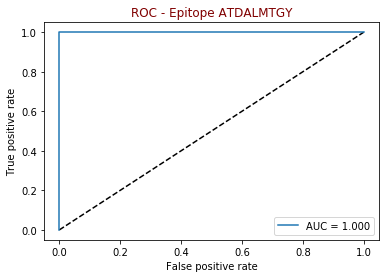

In [24]:
proxy.plot_ROC()

In [25]:
proxy.prox_df

,epitope,subject,epitope_group,nn_score,predicted_p,ground_truth
0,ATDALMTGY,NaN,ATDALMTGY,51.3333,0.982524,1
1,ATDALMTGY,NaN,ATDALMTGY,62,0.858252,1
2,ATDALMTGY,NaN,ATDALMTGY,49.8333,1,1
3,AVFDRKSDAK,NaN,other,76,0.695146,0
4,CINGVCWTV,NaN,other,91.5,0.514563,0
...,...,...,...,...,...,...
95,TPQDLNTML,NaN,other,82.1667,0.623301,0
96,TPRVTGGGAM,NaN,other,98.5,0.43301,0
97,VTEHDTLLY,NaN,other,83.1667,0.61165,0
98,YVLDHLIVV,NaN,other,96.1667,0.460194,0
